In [ ]:
# Standard Imports
import pandas as pd
import numpy as np
import os
import time
import joblib

# Machine Learning and Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier as HGBoost
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.metrics import log_loss, make_scorer
from sklearn.base import clone
from sklearn.metrics import brier_score_loss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = "/content/drive/MyDrive/Diffusion_Indices_Project/"
RESULTS_PATH = os.path.join(BASE_PATH, "04_results")
INTERMEDIATE_PATH = os.path.join(BASE_PATH, "03_intermediate_data")
SUB_INDICES_PATH = os.path.join(RESULTS_PATH, 'sub_indices_for_tuning')


y_target_full = pd.read_pickle(os.path.join(INTERMEDIATE_PATH, 'y_target.pkl'))

MODELS_TO_RUN = {
    'Logit': LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=42),
    'Logit_L1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42),
    'HGBoost': HGBoost(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(random_state=42),
}
LAGS_TO_ADD = [1, 2, 3, 6, 9, 12]
OOS_START_DATE = '1990-01-01'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def add_lags(df, lags_to_add, prefix=''):
    """
    Adds lagged versions of columns to a DataFrame.
    """
    if not lags_to_add:
        return df

    df_lagged = df.copy()
    for lag in lags_to_add:
        df_shifted = df.shift(lag)
        df_shifted.columns = [f'{prefix}{col}_lag{lag}' for col in df.columns]
        df_lagged = pd.concat([df_lagged, df_shifted], axis=1)

    return df_lagged

--- Testing LASSO with C = 100.0 ---
Brier Score for C=100.0: 0.05232
--- Testing LASSO with C = 50.0 ---
Brier Score for C=50.0: 0.05224
--- Testing LASSO with C = 20.0 ---
Brier Score for C=20.0: 0.05214
--- Testing LASSO with C = 10.0 ---
Brier Score for C=10.0: 0.05204
--- Testing LASSO with C = 5.0 ---
Brier Score for C=5.0: 0.05197
--- Testing LASSO with C = 1.0 ---
Brier Score for C=1.0: 0.05173
--- Testing LASSO with C = 0.5 ---
Brier Score for C=0.5: 0.05121
--- Testing LASSO with C = 0.2 ---
Brier Score for C=0.2: 0.05024
--- Testing LASSO with C = 0.1 ---
Brier Score for C=0.1: 0.04973
--- Testing LASSO with C = 0.05 ---
Brier Score for C=0.05: 0.04891
--- Testing LASSO with C = 0.01 ---
Brier Score for C=0.01: 0.24987


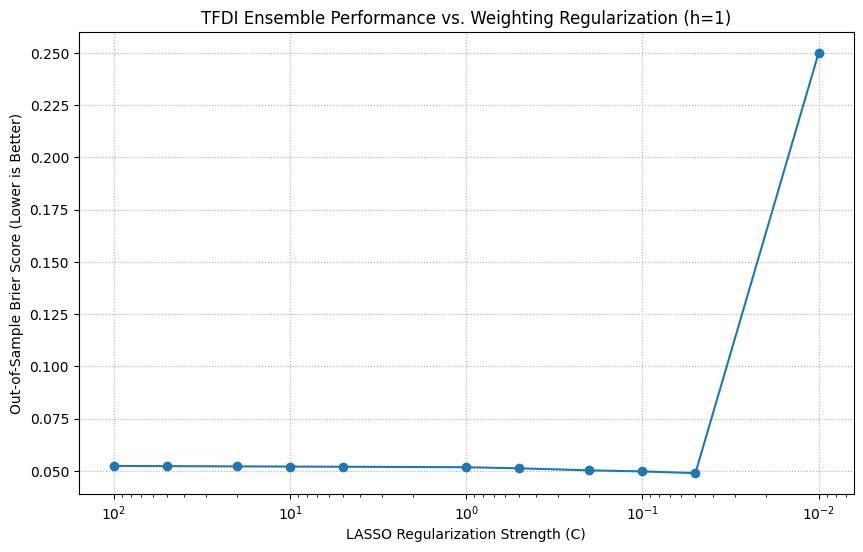


Final Brier Scores by C value:
0.05      0.048911
0.10      0.049728
0.20      0.050238
0.50      0.051208
1.00      0.051730
5.00      0.051970
10.00     0.052041
20.00     0.052141
50.00     0.052245
100.00    0.052317
0.01      0.249867
dtype: float64


In [ ]:

PREDICTION_HORIZON = 3
C_VALUES_TO_TEST = [100.0, 50.0, 20.0, 10.0, 5.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.01] # Expanded grid
horizon_sub_index_path = os.path.join(SUB_INDICES_PATH, f'h{PREDICTION_HORIZON}')


final_brier_scores = {}



for c_val in C_VALUES_TO_TEST:
    print(f"--- Testing LASSO with C = {c_val} ---")

    oos_probs_for_c = {model_name: [] for model_name, model in MODELS_TO_RUN.items()}

    forecast_dates = y_target_full.index[y_target_full.index >= pd.to_datetime(OOS_START_DATE)]

    for forecast_date in forecast_dates:
        train_end_date = forecast_date - pd.DateOffset(months=PREDICTION_HORIZON)
        y_train_full = y_target_full.loc[:train_end_date, 'USRECM']
        y_actual = y_target_full.loc[forecast_date, 'USRECM']

        try:
            sub_index_filename = f'sub_indices_TFDI_{forecast_date.strftime("%Y-%m-%d")}.pkl'
            all_sub_indices = joblib.load(os.path.join(horizon_sub_index_path, sub_index_filename))
        except FileNotFoundError:
            for model_name in MODELS_TO_RUN:
                oos_probs_for_c[model_name].append(np.nan)
            continue

        y_shifted = y_train_full.shift(-PREDICTION_HORIZON).rename('y_lead')
        weighting_data = pd.concat([y_shifted, all_sub_indices], axis=1, join='inner').dropna()
        y_weight = weighting_data['y_lead']
        X_weight = weighting_data.drop(columns=['y_lead'])

        weights = pd.Series(1.0, index=X_weight.columns)
        if len(y_weight.unique()) == 2 and not X_weight.empty:
            model_lasso = LogisticRegression(penalty='l1', C=c_val, solver='liblinear', class_weight='balanced', random_state=42)
            model_lasso.fit(X_weight, y_weight)
            weights = pd.Series(np.abs(model_lasso.coef_[0]), index=X_weight.columns)

        weighted_sub_indices = all_sub_indices.mul(weights)

        X_train_raw = weighted_sub_indices
        X_train_lagged = add_lags(X_train_raw, LAGS_TO_ADD)
        X_predict_point = X_train_lagged.iloc[[-1]]
        X_train_final = X_train_lagged.dropna()

        for model_name, model_template in MODELS_TO_RUN.items():
            prob = np.nan
            try:
                prob, error = np.nan, np.nan

                try:
                    common_index = y_train_full.index.intersection(X_train_final.index)
                    y_train_aligned = y_train_full.loc[common_index]
                    X_train_aligned = X_train_final.loc[common_index]

                    if len(X_train_aligned) > max(LAGS_TO_ADD, default=0) + 20:
                        model_instance = clone(model_template)

                        if 'XGBoost' in model_name:
                            neg, pos = (y_train_aligned == 0).sum(), (y_train_aligned == 1).sum()
                            if pos > 0: model_instance = model_template.set_params(scale_pos_weight=(neg/pos))
                        elif 'HGBoost' in model_name or 'RandomForest' in model_name or 'Logit' in model_name:
                            model_instance = model_template.set_params(class_weight='balanced')

                        X_predict_imputed = X_predict_point.reindex(columns=X_train_aligned.columns).fillna(X_train_aligned.mean())

                        if not X_predict_imputed.isna().any().any():
                            model_instance.fit(X_train_aligned, y_train_aligned)
                            prob = model_instance.predict_proba(X_predict_imputed)[:, 1][0]
                            error = (y_actual - prob)**2
                except Exception:
                    pass
                oos_probs_for_c[model_name].append(prob)
            except Exception:
                oos_probs_for_c[model_name].append(np.nan)

    prob_df_for_c = pd.DataFrame(oos_probs_for_c, index=forecast_dates)
    ensemble_prob = prob_df_for_c.mean(axis=1)

    aligned_df = pd.concat([y_target_full['USRECM'], ensemble_prob], axis=1).dropna()
    brier = brier_score_loss(aligned_df.iloc[:, 0], aligned_df.iloc[:, 1])

    final_brier_scores[c_val] = brier
    print(f"Brier Score for C={c_val}: {brier:.5f}")


scores = pd.Series(final_brier_scores)
plt.figure(figsize=(10, 6))
plt.plot(scores.index, scores.values, marker='o')
plt.xscale('log')
plt.xlabel('LASSO Regularization Strength (C)')
plt.ylabel('Out-of-Sample Brier Score (Lower is Better)')
plt.title('TFDI Ensemble Performance vs. Weighting Regularization (h=1)')
plt.grid(True, linestyle=':')
plt.gca().invert_xaxis()
plt.show()

print("\nFinal Brier Scores by C value:")
print(scores.sort_values())